In [1]:
import torch
import numpy as np
import os, sys
device = 0
os.environ["CUDA_VISIBLE_DEVICES"] = str(device)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from data.dataset import CustomTokenizer
from transformers import GPT2Config
# from data.circle import make_dataset, compute_canonical_permutation
from data.permutation import make_dataset, compute_canonical_permutation

from model.networks import AttentionOnlyLMHeadModel
from model.eval import decode_batch, generate_samples
from model.train import train_main
from model.utils import set_seed
from data.dataset import collate_fn

%load_ext autoreload
%autoreload 2

/scratch/cluster/vansh/miniconda/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")

# define dataset parameters
dataset_name = "circle"
model_type = "attention-only-12"
model_path = None

M = 15
N = 9
H = 26
HL = 0
seed_per_pi = False
num_train_samples =10000
batch_size = 32
num_eval_samples = 1000
eval_batch_size = 256
num_ckpts = 20
epochs = 30
eval_runs = 1
top_p=1.0
save_name = f"M{M}-N{N}-H{H}-NT{num_train_samples}-E{epochs}-top_p{top_p}-{model_type}"
data_root = f"/datastor1/vansh/lang_sampling/data"
regenerate_data = False

In [3]:
tokenizer = CustomTokenizer(padding_side='left')
# tokenizer.padding_side = 'left'  # Ensure left-padding for decoder-only architecture
train_dataset, test_dataset, tokenizer, train_strs, train_perms, VOCAB, SEED_TOKENS, EVAL_TOKENIZER = make_dataset(
                                                                                                                    M=M,
                                                                                                                    N=N,
                                                                                                                    H=H,
                                                                                                                    seed_len=HL,
                                                                                                                    seed_per_pi=seed_per_pi,
                                                                                                                    num_train_samples=num_train_samples,
                                                                                                                    num_test_samples=num_eval_samples,
                                                                                                                    tokenizer=tokenizer,
                                                                                                                    data_root=data_root,
                                                                                                                    regenerate=regenerate_data
                                                                                                                )
VOCAB_IDs = {EVAL_TOKENIZER._convert_token_to_id(tok) for tok in VOCAB}
data_collator = lambda features: collate_fn(features, tokenizer=tokenizer)

BOS token: <BOS>, ID: 19
EOS token: <EOS>, ID: 20
PAD token: <EOS>, ID: 20
Loading existing dataset from /datastor1/vansh/lang_sampling/data/circle/M15-N9
Generated and saved 0 unique seeds for the strings.


In [4]:
tokenizer.get_vocab()

{'[PAD]': 0,
 '[SOS]': 1,
 '[EOS]': 2,
 '[UNK]': 3,
 'v0': 4,
 'v1': 5,
 'v2': 6,
 'v3': 7,
 'v4': 8,
 'v5': 9,
 'v6': 10,
 'v7': 11,
 'v8': 12,
 'v9': 13,
 'v10': 14,
 'v11': 15,
 'v12': 16,
 'v13': 17,
 'v14': 18,
 '<BOS>': 19,
 '<EOS>': 20,
 '<H0>': 21,
 '<H1>': 22,
 '<H2>': 23,
 '<H3>': 24,
 '<H4>': 25,
 '<H5>': 26,
 '<H6>': 27,
 '<H7>': 28,
 '<H8>': 29,
 '<H9>': 30,
 '<H10>': 31,
 '<H11>': 32,
 '<H12>': 33,
 '<H13>': 34,
 '<H14>': 35,
 '<H15>': 36,
 '<H16>': 37,
 '<H17>': 38,
 '<H18>': 39,
 '<H19>': 40,
 '<H20>': 41,
 '<H21>': 42,
 '<H22>': 43,
 '<H23>': 44,
 '<H24>': 45,
 '<H25>': 46}

In [5]:
train_dataset[0] 

{'input_ids': tensor([19,  4, 14, 16,  4,  9,  8, 10,  5, 12, 16, 14, 18,  5,  9,  8, 12, 18,
         10, 20]),
 'labels': tensor([-100,    4,   14,   16,    4,    9,    8,   10,    5,   12,   16,   14,
           18,    5,    9,    8,   12,   18,   10,   20]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}

In [11]:
collate_fn([train_dataset[0], train_dataset[3]], tokenizer=tokenizer)

{'input_ids': tensor([[19,  4, 14, 16,  4,  9,  8, 10,  5, 12, 16, 14, 18,  5,  9,  8, 12, 18,
          10, 20],
         [19,  6,  9, 10,  5,  4, 17,  7, 16, 15,  7, 17, 10, 16,  6,  5, 15,  9,
           4, 20]]),
 'labels': tensor([[-100,    4,   14,   16,    4,    9,    8,   10,    5,   12,   16,   14,
            18,    5,    9,    8,   12,   18,   10,   20],
         [-100,    6,    9,   10,    5,    4,   17,    7,   16,   15,    7,   17,
            10,   16,    6,    5,   15,    9,    4,   20]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [16]:
model_name = model_type.removesuffix("-pretrained")

if model_name == 'attention-only-2':
    config = GPT2Config(
        vocab_size=tokenizer.vocab_size, n_positions=128, n_layer=2,
        n_head=4, n_embd=128, bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id,
    )
elif model_name == 'attention-only-4':
    config = GPT2Config(
        vocab_size=tokenizer.vocab_size, n_positions=256, n_layer=4,
        n_head=8, n_embd=256, bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id,
    )
elif model_name == 'attention-only-12':
    config = GPT2Config(
        vocab_size=tokenizer.vocab_size, n_positions=1024, n_layer=12,
        n_head=12, n_embd=768, bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id,
    )
else:
    raise ValueError(f"No configuration defined for model type {model_type}")

# 3. Instantiate the model from scratch or load from a path
if "pretrained" in model_type:
    if not model_path:
        raise ValueError("Must provide 'model_path' in args when using a pretrained model.")
    print(f"Loading pretrained {model_name} model from {model_path}")
    model = AttentionOnlyLMHeadModel.from_pretrained(model_path)
else:
    print(f"Initializing new {model_name} model from scratch")
    model = AttentionOnlyLMHeadModel(config=config)

model.to(DEVICE)
model.resize_token_embeddings(len(tokenizer))
print(f"Model {model_name} initialized with {sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable parameters.")

Initializing new attention-only-12 model from scratch
Model attention-only-12 initialized with 29190912 trainable parameters.


In [10]:
train_perms_set = set(train_perms)
print(f"Training permutations set size: {len(train_perms_set)}")

def is_coherent_after_walk(seq, N, vocab_ids=VOCAB_IDs) -> bool:
    """
    Given that π exists (walk succeeded), check coherence:
    - correct number of edges
    - correct tokens
    """
    if len(seq) != 2 * N:
        return False

    vocab_set = set(vocab_ids)
    if any(token not in vocab_set for token in seq):
        return False

    return True

def evaluate_model(model, 
                greedy, 
                temperature, 
                label, 
                decode_fn, 
                train_dataset, 
                seed=42, 
                batch_size=eval_batch_size, 
                num_eval_samples=num_eval_samples,
                top_p=top_p):
    set_seed(seed)
    print(f"\nEvaluating {label} for seed {seed}...")

    samples, outputs = generate_samples(model, 
                                train_dataset, 
                                tokenizer,
                                decode_fn=decode_fn, 
                                greedy=greedy, 
                                seed_tokens=SEED_TOKENS, 
                                seed_len=HL, 
                                max_length=train_dataset[1]["labels"].shape[0],
                                temperature=temperature, 
                                top_p=top_p, 
                                num_samples=num_eval_samples, 
                                batch_size=batch_size
                                )
    print(f"Generated {len(samples)} samples.")
    tokenized_samples = [EVAL_TOKENIZER.encode(s) for s in samples]

    unique_perms = set()
    unique_coherent_perms = set()
    num_coherent = 0
    incoherent_samples = []
    # Final metrics loop
    for s in tokenized_samples:
        pi = compute_canonical_permutation(s, N=N)
        if pi is not None:
            unique_perms.add(pi)
            if is_coherent_after_walk(s, N=N, vocab_ids=VOCAB_IDs):
                num_coherent += 1
                unique_coherent_perms.add(pi)
            else:
                incoherent_samples.append(s)
        else:
            incoherent_samples.append(s)

    num_unique_samples = len(set([tuple(s) for s in tokenized_samples])) 

    num_memorized = len([s for s in unique_coherent_perms if s in train_perms_set])
    num_creative = len([s for s in unique_coherent_perms if s not in train_perms_set])
    num_unique_perms = len(unique_perms)

    representation_power = (num_memorized / len(samples))
    creativity = (num_creative / len(samples)) 
    uniqueness = (num_unique_perms / len(samples)) 
    coherence = (num_coherent / len(samples)) 

    uniqueness_strings = (num_unique_samples / len(samples)) 
    # perplexity = compute_perplexity(model, test_dataset, batch_size=batch_size)

    # print(f"Perplexity: {perplexity:.4f}")
    print(f"Coherence: {coherence:.4f} ({num_coherent}/{len(samples)})")
    print(f"Representation power: {representation_power:.4f} ({num_memorized}/{len(samples)})")
    print(f"Creativity: {creativity:.4f} ({num_creative}/{len(samples)})")
    print(f"Uniqueness (permutations): {uniqueness:.4f} ({num_unique_perms}/{len(samples)})")
    print(f"Uniqueness (strings): {uniqueness_strings:.4f} ({num_unique_samples}/{len(samples)})")

    return np.array([
        representation_power,
        creativity,
        uniqueness,
        coherence,
        len(samples)
    ])

Training permutations set size: 8870



--- Running Learning Rate Finder ---


100%|██████████| 100/100 [00:05<00:00, 16.84it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.79E-04


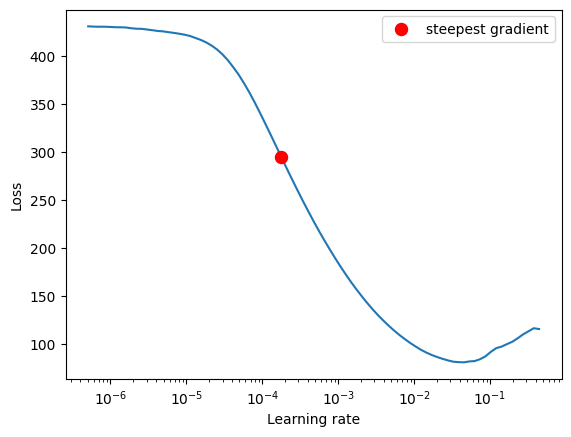

LR Finder plot saved to lr_finder.png

--- LR Finder complete. You can now use the suggested LR for training. ---


In [ ]:
# from torch_lr_finder import LRFinder, TrainDataLoaderIter
# import torch.optim as optim
# import torch.nn as nn

# class HFTrainLoaderIter(TrainDataLoaderIter):
#     def inputs_labels_from_batch(self, batch_data):
#         return batch_data, batch_data["labels"]

# class ModelWrapper(nn.Module):
#     def __init__(self, model):
#         super().__init__()
#         self.model = model

#     def forward(self, inputs):
#         return self.model(**inputs)

# def hf_criterion(outputs, labels):
#     return outputs.loss


# train_loader = torch.utils.data.DataLoader(
#     train_dataset,
#     batch_size=batch_size, # Use the same batch size as your main training
#     collate_fn=data_collator,
#     shuffle=True
# )


# # --- LR Finder ---
# print("\n--- Running Learning Rate Finder ---")

# # 1. Wrap the model
# wrapped_model = ModelWrapper(model)

# # 2. Define optimizer
# optimizer = optim.Adam(wrapped_model.parameters(), lr=1e-7, weight_decay=0.01)

# # 3. Wrap the DataLoader
# hf_train_iter = HFTrainLoaderIter(train_loader)

# # 4. Initialize and run the finder
# lr_finder = LRFinder(wrapped_model, optimizer, hf_criterion, device=DEVICE)
# lr_finder.range_test(hf_train_iter, end_lr=1, num_iter=100)

# # 5. Plot and reset
# lr_finder.plot() # Saves lr_finder.png
# print("LR Finder plot saved to lr_finder.png")
# lr_finder.reset()

# print("\n--- LR Finder complete. You can now use the suggested LR for training. ---")



In [ ]:
train_main(
    model=model,
    dataset_name=dataset_name,
    save_name=save_name,
    hl=HL,
    batch_size=batch_size,
    num_epochs=epochs,
    temperatures=[0.3, 0.5, 0.7, 1.0, 2.0],
    num_eval_runs=eval_runs,
    train_dataset=train_dataset,
    data_collator=data_collator,
    device=DEVICE,
    decode_fn=decode_batch,
    eval_fn=evaluate_model,
    num_checkpoints=num_ckpts,
    log_to_wandb=False,
    save_results=True, 
    lr=1e-4
)

{'loss': 131.5427, 'grad_norm': 13.960368156433105, 'learning_rate': 9.979765708200214e-05, 'epoch': 0.06389776357827476}
{'loss': 15.1895, 'grad_norm': 9.14792537689209, 'learning_rate': 9.958466453674123e-05, 'epoch': 0.12779552715654952}
{'loss': 6.5105, 'grad_norm': 12.136990547180176, 'learning_rate': 9.93716719914803e-05, 'epoch': 0.19169329073482427}
{'loss': 5.9177, 'grad_norm': 13.961338996887207, 'learning_rate': 9.915867944621938e-05, 'epoch': 0.25559105431309903}
{'loss': 5.8031, 'grad_norm': 15.695869445800781, 'learning_rate': 9.894568690095847e-05, 'epoch': 0.3194888178913738}
{'loss': 5.5912, 'grad_norm': 11.409133911132812, 'learning_rate': 9.873269435569755e-05, 'epoch': 0.38338658146964855}
{'loss': 5.4723, 'grad_norm': 7.549466133117676, 'learning_rate': 9.851970181043664e-05, 'epoch': 0.4472843450479233}
{'loss': 5.544, 'grad_norm': 10.738810539245605, 'learning_rate': 9.830670926517573e-05, 'epoch': 0.5111821086261981}
{'loss': 5.3783, 'grad_norm': 9.7768955230712

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📈 Live evaluation at step 469

Evaluating Step 469 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Generated 1000 samples.
Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 469 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Generated 1000 samples.
Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 469 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Generated 1000 samples.
Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 469 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.
Generated 1000 samples.
Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📈 Live evaluation at step 938

Evaluating Step 938 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Generated 1000 samples.
Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 938 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Generated 1000 samples.
Coherence: 0.0330 (33/1000)
Representation power: 0.0040 (4/1000)
Creativity: 0.0260 (26/1000)
Uniqueness (permutations): 0.0300 (30/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 938 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Generated 1000 samples.
Coherence: 0.0100 (10/1000)
Representation power: 0.0030 (3/1000)
Creativity: 0.0070 (7/1000)
Uniqueness (permutations): 0.0100 (10/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 938 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.
Generated 1000 samples.
Coherence: 0.0060 (6/1000)
Representation power: 0.0010 (1/1000)
Creativity: 0.0050 (5

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📈 Live evaluation at step 1407

Evaluating Step 1407 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Generated 1000 samples.
Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 1407 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Generated 1000 samples.
Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.9880 (988/1000)

Evaluating Step 1407 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Generated 1000 samples.
Coherence: 0.0020 (2/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0020 (2/1000)
Uniqueness (permutations): 0.0020 (2/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 1407 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.
Generated 1000 samples.
Coherence: 0.0090 (9/1000)
Representation power: 0.0020 (2/1000)
Creativity: 0.0070 (7/10

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📈 Live evaluation at step 1876

Evaluating Step 1876 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Generated 1000 samples.
Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 1876 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Generated 1000 samples.
Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.9960 (996/1000)

Evaluating Step 1876 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Generated 1000 samples.
Coherence: 0.0010 (1/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0010 (1/1000)
Uniqueness (permutations): 0.0010 (1/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 1876 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.
Generated 1000 samples.
Coherence: 0.0160 (16/1000)
Representation power: 0.0050 (5/1000)
Creativity: 0.0110 (11/

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📈 Live evaluation at step 2345

Evaluating Step 2345 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Generated 1000 samples.
Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 2345 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Generated 1000 samples.
Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.9970 (997/1000)

Evaluating Step 2345 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Generated 1000 samples.
Coherence: 0.0020 (2/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0020 (2/1000)
Uniqueness (permutations): 0.0020 (2/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 2345 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.
Generated 1000 samples.
Coherence: 0.0260 (26/1000)
Representation power: 0.0040 (4/1000)
Creativity: 0.0220 (22/

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📈 Live evaluation at step 2814

Evaluating Step 2814 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Generated 1000 samples.
Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 2814 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Generated 1000 samples.
Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.9990 (999/1000)

Evaluating Step 2814 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Generated 1000 samples.
Coherence: 0.0020 (2/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0020 (2/1000)
Uniqueness (permutations): 0.0020 (2/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 2814 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.
Generated 1000 samples.
Coherence: 0.0350 (35/1000)
Representation power: 0.0120 (12/1000)
Creativity: 0.0230 (23

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


{'loss': 2.1472, 'grad_norm': 3.786224603652954, 'learning_rate': 6.507987220447285e-05, 'epoch': 10.47923322683706}

📈 Live evaluation at step 3283

Evaluating Step 3283 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Generated 1000 samples.
Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 3283 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Generated 1000 samples.
Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.9990 (999/1000)

Evaluating Step 3283 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Generated 1000 samples.
Coherence: 0.0150 (15/1000)
Representation power: 0.0020 (2/1000)
Creativity: 0.0130 (13/1000)
Uniqueness (permutations): 0.0150 (15/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 3283 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.
Generated 1000 samples.
Coherence: 0.0500 (50/1000)
Representation power: 0.0090 (9/1000)
Creativity: 0.0410 (

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📈 Live evaluation at step 3752

Evaluating Step 3752 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Generated 1000 samples.
Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 3752 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Generated 1000 samples.
Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 3752 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Generated 1000 samples.
Coherence: 0.0080 (8/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0080 (8/1000)
Uniqueness (permutations): 0.0080 (8/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 3752 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.


In [37]:
tokenizer.convert_tokens_to_ids(tokenizer.all_special_tokens)

[19,
 20,
 3,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46]

In [5]:
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
model_path = os.path.join("/datastor1/vansh/lang_sampling/results/", dataset_name, save_name, "best_models", f"HL{HL}.pt")
# Load the model. It will automatically find and use the .safetensors file.
model = AttentionOnlyLMHeadModel.from_pretrained(model_path).to(DEVICE)
# You can also load the tokenizer from the same directory
# tokenizer = CustomTokenizer.from_pretrained(model_path)

In [18]:
def visualize_average_attention(model, tokenizer, num_samples=1000, max_length=20, output_ids=None):
    """
    Generates multiple sequences, averages their last-layer attention maps,
    and plots the result.
    """
    model.eval()
    attention_maps_by_len = defaultdict(list)
    
    print(f"\n--- Generating {num_samples} samples for attention analysis ---")
    
    # 1. Generate one batch of samples efficiently.
    with torch.no_grad():
        # If output_ids is provided, use it; otherwise, generate new samples.
        if output_ids is not None:
            # Ensure output_ids is a tensor and move to device
            output_ids = torch.tensor(output_ids, dtype=torch.long).to(DEVICE)
            samples = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
        else:
            # Generate samples using the model
            print(f"Generating {num_samples} samples with max length {max_length}...")
            samples, output_ids = generate_samples(
                model, 
                train_dataset, 
                tokenizer,
                decode_fn=decode_batch, 
                greedy=False, 
                seed_tokens=SEED_TOKENS, 
                seed_len=HL, 
                max_length=max_length,
                temperature=1.0, 
                top_p=top_p, 
                num_samples=num_samples, 
                batch_size=batch_size
            )

            print(f"Generated {len(samples)} samples.")
            print(f"Output IDs shape: {output_ids.shape}")
        # 2. Perform a single forward pass on the generated IDs to get attentions.
        rich_outputs = model(input_ids=output_ids, output_attentions=True)
        attentions = rich_outputs.attentions # This is a tuple of tensors, one per layer

    # 3. Get the attention tensor from the LAST layer. Its shape is (batch, seq, seq).
    last_layer_attentions = attentions[-1]

    print(f"Processing attentions for a batch of {last_layer_attentions.shape[0]} samples.")

    # 4. Loop through the batch and collect each attention map.
    for i in range(last_layer_attentions.shape[0]):
        attention_map = last_layer_attentions[i].cpu().numpy()
        seq_len = attention_map.shape[0]
        attention_maps_by_len[seq_len].append(attention_map)

    # --- END OF CORRECTED LOGIC ---

    # Find the most common sequence length to average over
    if not attention_maps_by_len:
        print("No samples generated. Cannot visualize attention.")
        return
        
    most_common_len = max(attention_maps_by_len, key=lambda k: len(attention_maps_by_len[k]))
    maps_to_average = attention_maps_by_len[most_common_len]
    
    print(f"Averaging attention maps for {len(maps_to_average)} samples of length {most_common_len}.")
    
    # Average the attention maps
    average_attention_map = np.mean(maps_to_average, axis=0)
    
    # --- Visualization ---
    readable_sequence = ['<BOS>'] + [f'T{i+1}' for i in range(most_common_len - 1)]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(average_attention_map, cmap='viridis')

    ax.set_xticks(np.arange(len(readable_sequence)))
    ax.set_yticks(np.arange(len(readable_sequence)))
    
    ax.set_xticklabels(readable_sequence)
    ax.set_yticklabels(readable_sequence)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    ax.set_xlabel("Key Position (Attending To)")
    ax.set_ylabel("Query Position (Generating From)")
    ax.set_title(f"Average Attention Heatmap (Last Layer) over {len(maps_to_average)} samples")
    fig.colorbar(im)
    fig.tight_layout()
    
    plt.savefig("average_attention_heatmap.png")
    print("\nSaved average attention heatmap to average_attention_heatmap.png")



--- Generating 1000 samples for attention analysis ---
Generating 1000 samples with max length 20...

Generating 1000 unconditional samples.
Generated 1000 samples.
Output IDs shape: torch.Size([1000, 20])
Processing attentions for a batch of 1000 samples.
Averaging attention maps for 1000 samples of length 20.

Saved average attention heatmap to average_attention_heatmap.png


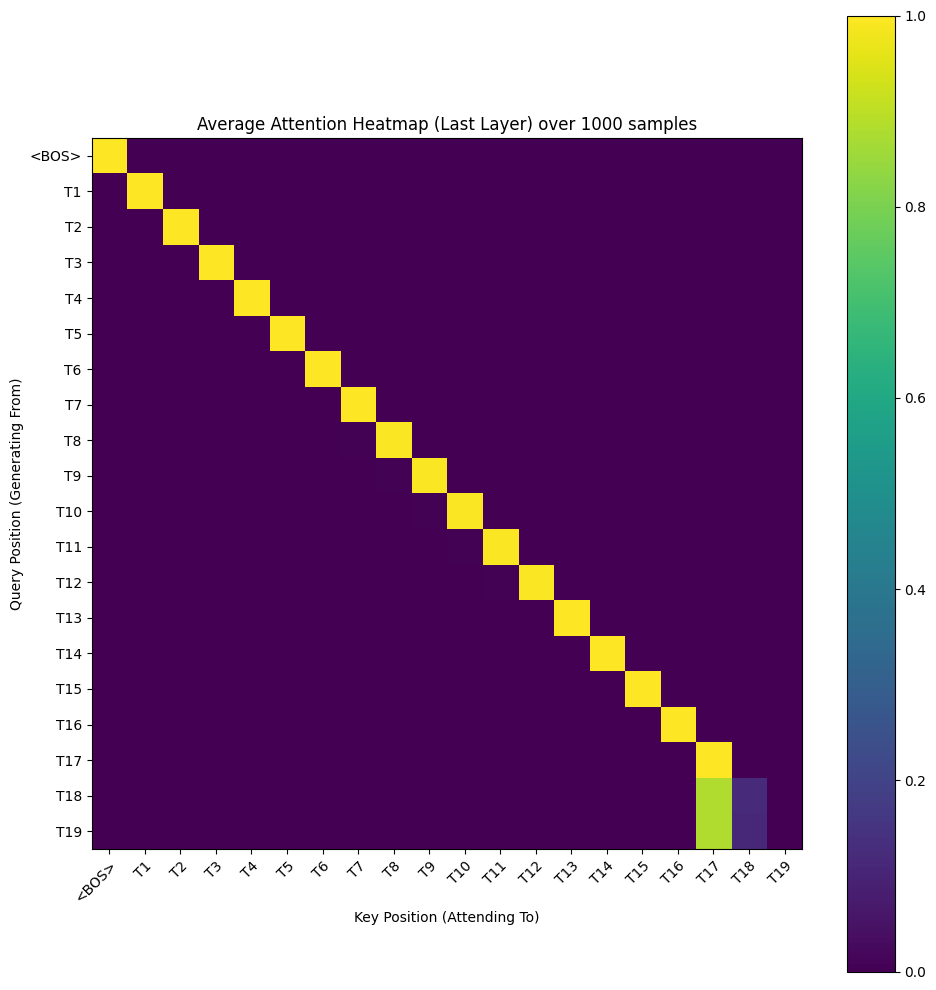

In [19]:
visualize_average_attention(model, tokenizer, num_samples=1000, max_length=train_dataset[1]["labels"].shape[0])

In [8]:
samples, outputs = generate_samples(model, 
                                train_dataset, 
                                tokenizer,
                                decode_fn=decode_batch, 
                                greedy=False, 
                                seed_tokens=SEED_TOKENS, 
                                seed_len=HL, 
                                max_length=train_dataset[1]["labels"].shape[0],
                                temperature=1.0, 
                                top_p=top_p, 
                                num_samples=num_eval_samples, 
                                batch_size=batch_size
                                )
samples


Generating 1000 unconditional samples.


['v4 v13 v11 v12 v10 v5 v0 v2 v7 v14 v13 v4 v2 v0 v14 v10 v5 v7',
 'v14 v5 v9 v2 v7 v14 v2 v7 v8 v7 v5 v12 v11 v9 v7 v11 v12 v8',
 'v3 v1 v2 v5 v8 v6 v1 v2 v6 v7 v13 v8 v5 v3 v7 v13 v8 v12',
 'v4 v7 v1 v0 v2 v12 v11 v6 v12 v1 v6 v3 v7 v13 v3 v11 v13 v2',
 'v7 v8 v3 v7 v10 v3 v14 v6 v8 v12 v6 v14 v12 v1 v1 v10 v4 v2',
 'v12 v0 v14 v1 v10 v2 v5 v14 v1 v5 v2 v4 v0 v6 v4 v12 v6 v10',
 'v1 v5 v13 v12 v0 v9 v2 v4 v5 v14 v9 v0 v4 v6 v14 v13 v12 v1',
 'v10 v14 v5 v7 v4 v7 v8 v10 v7 v13 v14 v8 v7 v5 v13 v4 v7 v0',
 'v11 v2 v8 v0 v2 v6 v9 v5 v0 v4 v3 v11 v6 v9 v4 v3 v5 v8',
 'v13 v4 v10 v11 v3 v12 v12 v2 v2 v13 v7 v10 v11 v3 v4 v7 v11 v11',
 'v6 v7 v2 v13 v7 v14 v8 v12 v9 v6 v14 v8 v13 v2 v12 v9 v13 v13',
 'v2 v8 v7 v13 v14 v5 v4 v10 v6 v4 v8 v2 v10 v6 v5 v14 v13 v7',
 'v6 v12 v2 v14 v13 v6 v12 v13 v7 v0 v0 v12 v3 v2 v14 v8 v8 v3',
 'v6 v0 v2 v6 v8 v10 v4 v2 v5 v3 v12 v8 v0 v4 v10 v12 v3 v5',
 'v12 v14 v8 v10 v7 v4 v2 v8 v14 v9 v9 v12 v4 v7 v3 v2 v10 v3',
 'v7 v8 v13 v4 v2 v9 v9 v11 v0 v13 v11 v

In [13]:
tokenized_samples = [EVAL_TOKENIZER.encode(s) for s in samples]

unique_perms = set()
unique_coherent_perms = set()
num_coherent = 0
incoherent_samples = []
coherent_outputs = []
# Final metrics loop
for i in range(len(tokenized_samples)):
    s = tokenized_samples[i]
    pi = compute_canonical_permutation(s, N=N)
    if pi is not None:
        unique_perms.add(pi)
        if is_coherent_after_walk(s, N=N, vocab_ids=VOCAB_IDs):
            num_coherent += 1
            coherent_outputs.append(outputs[i])
            unique_coherent_perms.add(pi)
        else:
            incoherent_samples.append(s)
    else:
        incoherent_samples.append(s)


num_memorized = len([s for s in unique_coherent_perms if s in train_perms_set])
num_creative = len([s for s in unique_coherent_perms if s not in train_perms_set])
num_unique = len(unique_perms)

representation_power = (num_memorized / len(samples))
creativity = (num_creative / len(samples)) 
uniqueness = (num_unique / len(samples)) 
coherence = (num_coherent / len(samples)) 
# perplexity = compute_perplexity(model, test_dataset, batch_size=batch_size)

# print(f"Perplexity: {perplexity:.4f}")
print(f"Coherence: {coherence:.4f} ({num_coherent}/{len(samples)})")
print(f"Representation power: {representation_power:.4f} ({num_memorized}/{len(samples)})")
print(f"Creativity: {creativity:.4f} ({num_creative}/{len(samples)})")
print(f"Uniqueness: {uniqueness:.4f} ({num_unique}/{len(samples)})")

Coherence: 0.1330 (133/1000)
Representation power: 0.0320 (32/1000)
Creativity: 0.1010 (101/1000)
Uniqueness: 0.1330 (133/1000)



--- Generating 1000 samples for attention analysis ---
Processing attentions for a batch of 133 samples.


/tmp/ipykernel_3973107/1123018825.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output_ids = torch.tensor(output_ids, dtype=torch.long).to(DEVICE)


Averaging attention maps for 133 samples of length 20.

Saved average attention heatmap to average_attention_heatmap.png


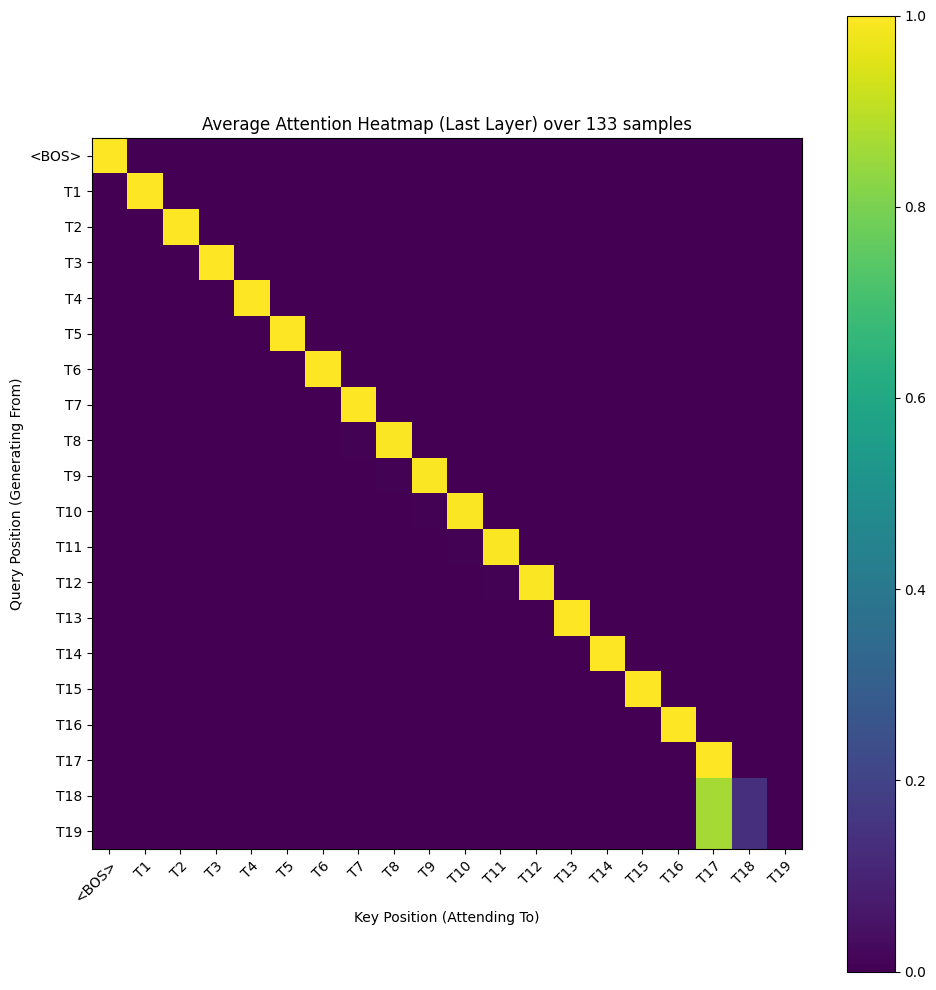

In [20]:
coherent_output_ids = torch.cat(coherent_outputs, dim=0).reshape(-1, train_dataset[1]["labels"].shape[0])
coherent_output_ids.shape
visualize_average_attention(model, tokenizer, num_samples=1000, max_length=train_dataset[1]["labels"].shape[0], output_ids=coherent_output_ids)


In [8]:
def visualize_average_attention(model, tokenizer, num_samples=100, max_length=20, device="cpu"):
    """
    Generates multiple sequences using a manual loop to reliably capture attention,
    averages the last-layer attention maps, and plots the result.
    """
    model.eval()
    attention_maps_by_len = defaultdict(list)
    
    print(f"\n--- Generating {num_samples} samples for attention analysis ---")
    for _ in tqdm(range(num_samples)):
        input_ids = torch.tensor([[tokenizer.bos_token_id]], device=device)
        
        with torch.no_grad():
            # Manual generation loop
            for _ in range(max_length - 1):
                outputs = model(input_ids=input_ids, output_attentions=True)
                
                # Get logits for the next token
                next_token_logits = outputs.logits[:, -1, :]
                # Use sampling (e.g., top-k)
                top_k = 5
                v, _ = torch.topk(next_token_logits, top_k)
                next_token_logits[next_token_logits < v[:, [-1]]] = -float('Inf')
                
                probs = torch.nn.functional.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
                
                input_ids = torch.cat([input_ids, next_token], dim=-1)
                
                if next_token.item() == tokenizer.eos_token_id:
                    break
            
            # After generating the full sequence, get the final attention map
            final_outputs = model(input_ids=input_ids, output_attentions=True)
            # `final_outputs.attentions` is a list of tensors, one per layer
            last_layer_attentions = final_outputs.attentions[-1] # Shape: (batch, heads, seq, seq)
            
            # We'll visualize the first head.
            attention_map = last_layer_attentions[0, 0].cpu().numpy()
            
            seq_len = attention_map.shape[0]
            attention_maps_by_len[seq_len].append(attention_map)

    # Find the most common sequence length to average over
    if not attention_maps_by_len:
        print("No samples generated. Cannot visualize attention.")
        return
        
    most_common_len = max(attention_maps_by_len, key=lambda k: len(attention_maps_by_len[k]))
    maps_to_average = attention_maps_by_len[most_common_len]
    
    print(f"Averaging attention maps for {len(maps_to_average)} samples of length {most_common_len}.")
    
    # Average the attention maps
    average_attention_map = np.mean(maps_to_average, axis=0)
    
    # --- Visualization ---
    # Create dummy tokens for axis labels
    readable_sequence = ['[SOS]'] + [f'T{i+1}' for i in range(most_common_len - 1)]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(average_attention_map, cmap='viridis')

    ax.set_xticks(np.arange(len(readable_sequence)))
    ax.set_yticks(np.arange(len(readable_sequence)))
    
    ax.set_xticklabels(readable_sequence)
    ax.set_yticklabels(readable_sequence)
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    ax.set_xlabel("Key Position (Attending To)")
    ax.set_ylabel("Query Position (Generating From)")
    ax.set_title(f"Average Attention Heatmap (Last Layer, First Head) over {len(maps_to_average)} samples")
    fig.colorbar(im)
    fig.tight_layout()
    
    plt.savefig("average_attention_heatmap.png")
    print("\nSaved average attention heatmap to average_attention_heatmap.png")
